In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from scipy import ndimage
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,BatchNormalization,Reshape,Conv2DTranspose,UpSampling2D
from tensorflow.keras.layers import Input , Lambda
from keras import backend as k

# Load the dataset:

In [3]:
import glob
data = glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/paper/*.png")
data += glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/rock/*.png")
data += glob.glob("/kaggle/input/rock-paper-scissors-dataset/Rock-Paper-Scissors/train/scissors/*.png")
images = [plt.imread(img) for img in data]
print(len(images))

2520


In [9]:
# Map for quick lookup
label_map = {'paper': 0, 'rock': 1, 'scissors': 2}

# Efficient list comprehension
Y = np.array([label_map.get(x.split('/')[-2]) for x in data])

# Shuffle the arrays consistently
images = np.array(images)
images, Y = shuffle(images, Y, random_state=0)

# Display some images:

In [10]:
def display(images,a):
        m,n = 1, int(len(images)/a)
        for i in range(0,len(images),m*n):
            fig = plt.figure(figsize=(15,8))
            for j in range(m*n):
                fig.add_subplot(m,n,j+1)
                plt.imshow(images[i+j])
                plt.axis('off')
            plt.show()

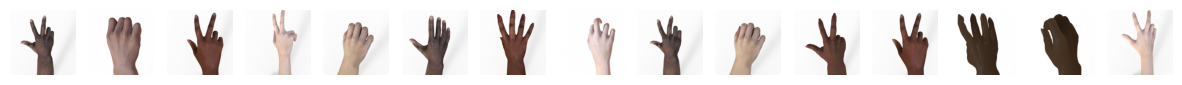

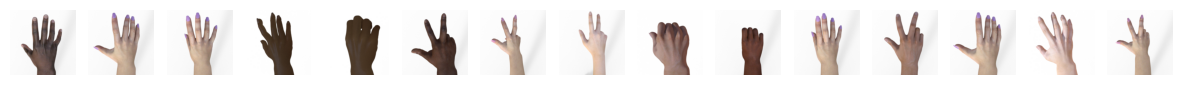

In [11]:
display(images[:30],2)

In [12]:
XTrain,XTest ,YTrain,YTest =train_test_split(images, Y, train_size=0.8)
print(f'Train: {len(XTrain)} images. \n Test: {len(XTest)} images.')

Train: 2016 images. 
 Test: 504 images.


# Blur the images:

In [13]:
from scipy.ndimage import uniform_filter

def blur(I: np.array):
    # Apply uniform filter for a blur effect
    pix_blur = (2, 2, 3)
    B = uniform_filter(I, size=pix_blur, mode='mirror')
    return B


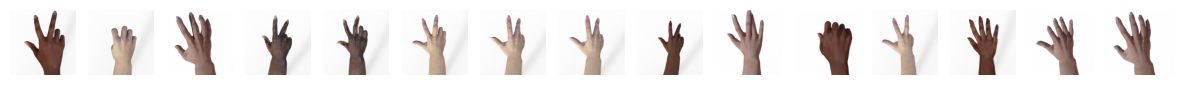

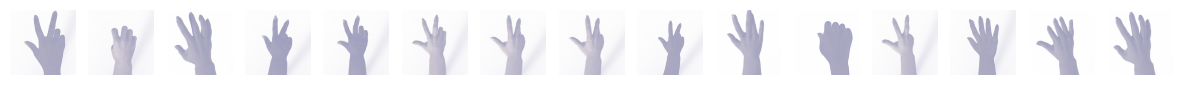

In [14]:
Btrain = [blur(img) for img in XTrain]
Btrain = np.array(Btrain)

# Display some images:
display(XTrain[:15],1)
display(Btrain[:15],1)

# The Model:

In [15]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder,self).__init__()
        # Encoder:
        self.encoder = Sequential()
        self.encoder.add(Conv2D(64,(3,3),1,activation = 'relu',input_shape=(300,300,4)))
        self.encoder.add(Conv2D(32,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(BatchNormalization())
        self.encoder.add(Conv2D(32,(3,3),1,activation = 'relu'))
        self.encoder.add(Conv2D(16,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(Conv2D(16,(3,3),1,activation = 'relu'))
        self.encoder.add(Conv2D(8,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(BatchNormalization())
        self.encoder.add(Conv2D(8,(3,3),1,activation = 'relu'))
        self.encoder.add(MaxPooling2D())
        self.encoder.add(BatchNormalization())
        self.encoder.add(Flatten())
        self.encoder.add(Dense(100))
        # Decoder:
        self.decoder = Sequential()
        self.decoder.add(Dense(units = 34*34*8,activation = 'relu',input_shape=(100,)))
        self.decoder.add(Reshape(target_shape = (34, 34, 8)))
        self.decoder.add(UpSampling2D((2, 2),interpolation="bilinear"))
        self.decoder.add(BatchNormalization())
        self.decoder.add(Conv2DTranspose(8,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        self.decoder.add(BatchNormalization())
        self.decoder.add(UpSampling2D((2,2),interpolation='bilinear'))
        self.decoder.add(Conv2DTranspose(32,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        self.decoder.add(UpSampling2D((2,2),interpolation='bilinear'))
        self.decoder.add(Conv2DTranspose(16,(3,3),1,activation = 'relu'))
        #self.decoder.add(Conv2DTranspose(8,(3,3),1,activation = 'relu'))
        self.decoder.add(Conv2DTranspose(4,(3,3),1,activation = 'sigmoid'))

    def call(self,x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode


In [16]:
deblur =  AutoEncoder()
opt = tf.keras.optimizers.Adam(clipvalue = 0.5)
deblur.compile(optimizer =opt,loss = tf.losses.MeanSquaredError(),metrics = ['accuracy'])
deblur.build((1000,300,300,4))
deblur.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "auto_encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       243,860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │       948,060 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,191,920 (4.55 MB)

 Trainable params: 1,191,776 (4.55 MB)

 Non-trainable params: 144 (576.00 B)

# Training the model:

In [18]:
hist = deblur.fit(Btrain,XTrain,epochs = 150, validation_split=0.3)

Epoch 1/150


I0000 00:00:1734009728.988460     126 service.cc:145] XLA service 0x7b8120009740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734009728.988508     126 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1734009728.988512     126 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-12-12 13:22:15.314301: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,296,296]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,298,298]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-12 13:22:15.411578: E external/loca

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.2554 - loss: 0.1489

2024-12-12 13:23:09.016306: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[29,32,296,296]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,64,298,298]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-12 13:23:09.120826: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.104620189s
Trying algorithm eng0{} for conv (f32[29,32,296,296]{3,2,1,0}, u8[0]{0}) custom-call(f32[29,64,298,298]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues"

45/45 ━━━━━━━━━━━━━━━━━━━━ 70s 836ms/step - accuracy: 0.2580 - loss: 0.1478 - val_accuracy: 0.5444 - val_loss: 0.0355
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 335ms/step - accuracy: 0.5850 - loss: 0.0351 - val_accuracy: 0.6137 - val_loss: 0.0266
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 342ms/step - accuracy: 0.6195 - loss: 0.0276 - val_accuracy: 0.6321 - val_loss: 0.0182
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 353ms/step - accuracy: 0.6332 - loss: 0.0176 - val_accuracy: 0.6509 - val_loss: 0.0134
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 372ms/step - accuracy: 0.6441 - loss: 0.0127 - val_accuracy: 0.6296 - val_loss: 0.0097
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step - accuracy: 0.6327 - loss: 0.0085 - val_accuracy: 0.6452 - val_loss: 0.0070
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 364ms/step - accuracy: 0.6407 - loss: 0.0063 - val_accuracy: 0.6323 - val_loss: 0.0053
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 356ms/step - accuracy: 0.6305 - loss: 0.0049 - val_accuracy

# Evaluating the model:

In [19]:
Btest = [blur(img) for img in XTest]
Btest = np.array(Btest)
deblur.evaluate(Btest,XTest)

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7993 - loss: 9.2874e-04

2024-12-12 14:07:10.366073: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[24,32,296,296]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,298,298]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-12-12 14:07:10.527844: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.161896775s
Trying algorithm eng0{} for conv (f32[24,32,296,296]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,298,298]{3,2,1,0}, f32[32,64,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues"

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 830ms/step - accuracy: 0.7993 - loss: 9.2985e-04


[0.000938225130084902, 0.7995378971099854]

## Display some samples:

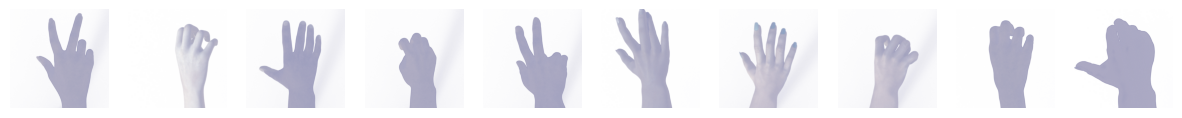

16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step


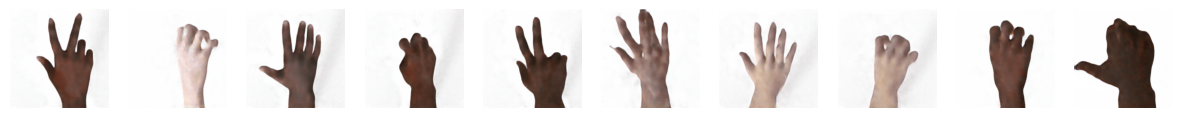

In [20]:
display(Btest[10:20],1)
DBtest = deblur.predict(Btest)
display(DBtest[10:20],1)